<a href="https://colab.research.google.com/github/qader48/weather-forcasting/blob/main/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import seaborn as sns
plt.style.use('fivethirtyeight')

In [3]:
from pathlib import Path
Path. cwd()

PosixPath('/content')

In [4]:
weather_data = pd.read_csv('/content/Weather_Data_1980_2024(hourly).csv')
weather_data.head()
weather_data = weather_data[weather_data['time'] <= '2023-12-31']

In [5]:
# Convert 'time' column to datetime format
weather_data['time'] = pd.to_datetime(weather_data['time'])

# Check for missing values
missing_values = weather_data.isnull().sum()

# Summary statistics for numerical columns
summary_statistics = weather_data.describe()

missing_values, summary_statistics

(time                             0
 temperature                      0
 relative_humidity                0
 dew_point                        0
 precipitation (mm)               0
 rain (mm)                        0
 snowfall (cm)                    0
 pressure_msl (hPa)               0
 surface_pressure (hPa)           0
 cloud_cover (%)                  0
 cloud_cover_low (%)              0
 cloud_cover_mid (%)              0
 cloud_cover_high (%)             0
 vapour_pressure_deficit (kPa)    0
 wind_speed_10m (km/h)            0
 wind_direction                   0
 is_Day                           0
 dtype: int64,
                                 time    temperature  relative_humidity  \
 count                         385680  385680.000000      385680.000000   
 mean   2001-12-30 23:30:00.000000640      24.108211          64.142940   
 min              1980-01-01 00:00:00       7.100000           6.000000   
 25%              1990-12-31 11:45:00      21.500000          42.000000  

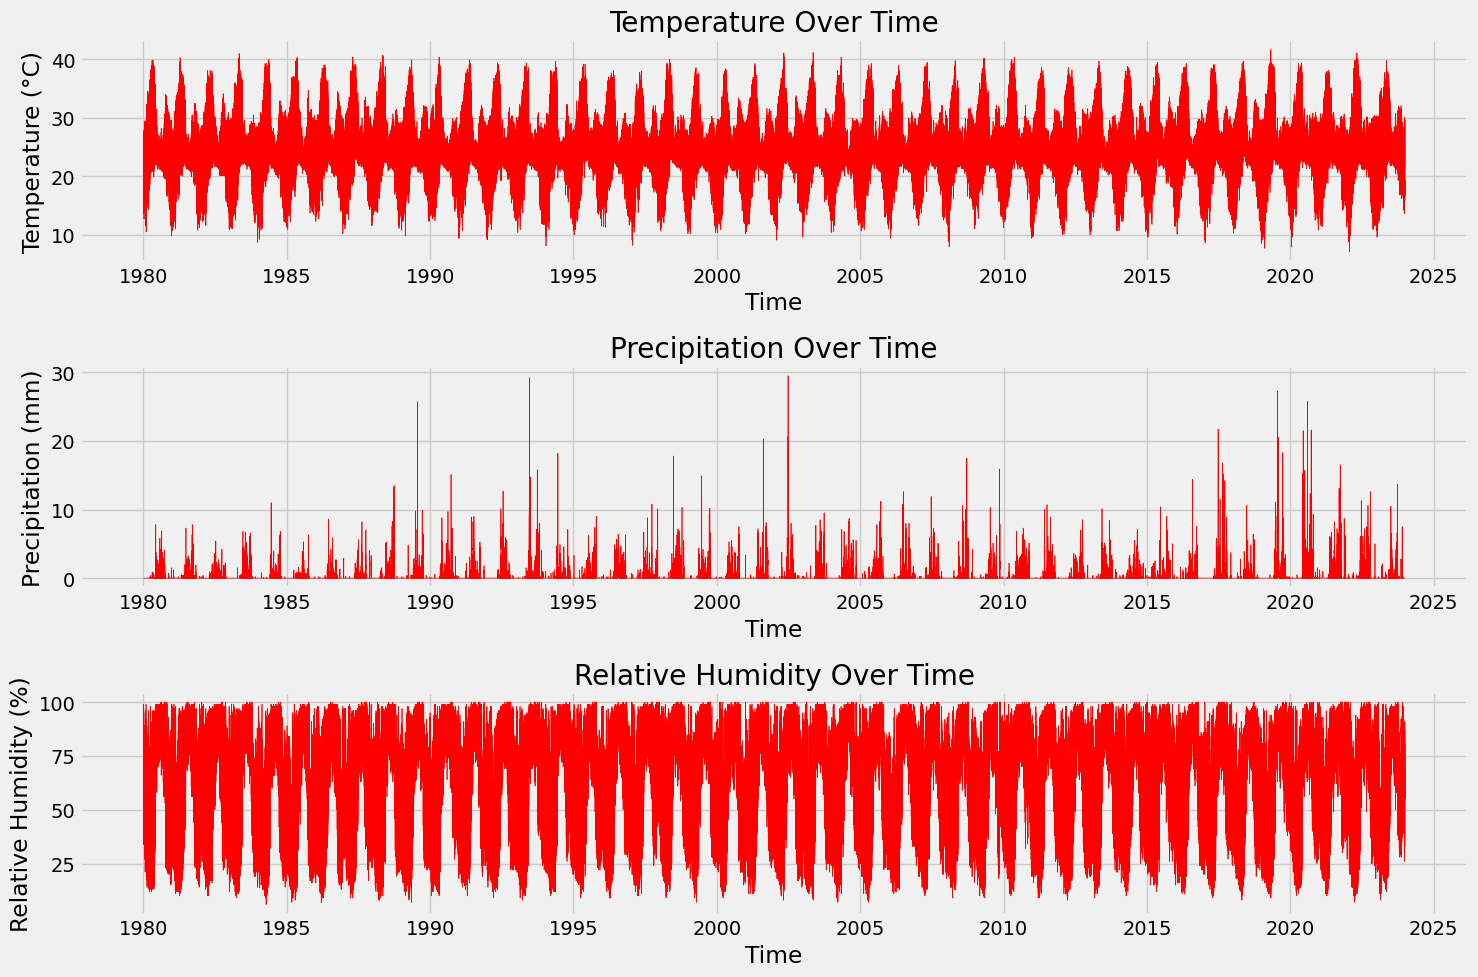

In [6]:
plt.figure(figsize=(15, 10))

# Plot temperature over time
plt.subplot(3, 1, 1)
plt.plot(weather_data['time'], weather_data['temperature'], color='red', linewidth=0.5)
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')

# Plot precipitation over time
plt.subplot(3, 1, 2)
plt.plot(weather_data['time'], weather_data['precipitation (mm)'], color='red', linewidth=0.5)
plt.title('Precipitation Over Time')
plt.xlabel('Time')
plt.ylabel('Precipitation (mm)')

# Plot relative humidity over time
plt.subplot(3, 1, 3)
plt.plot(weather_data['time'], weather_data['relative_humidity'], color='red', linewidth=0.5)
plt.title('Relative Humidity Over Time')
plt.xlabel('Time')
plt.ylabel('Relative Humidity (%)')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

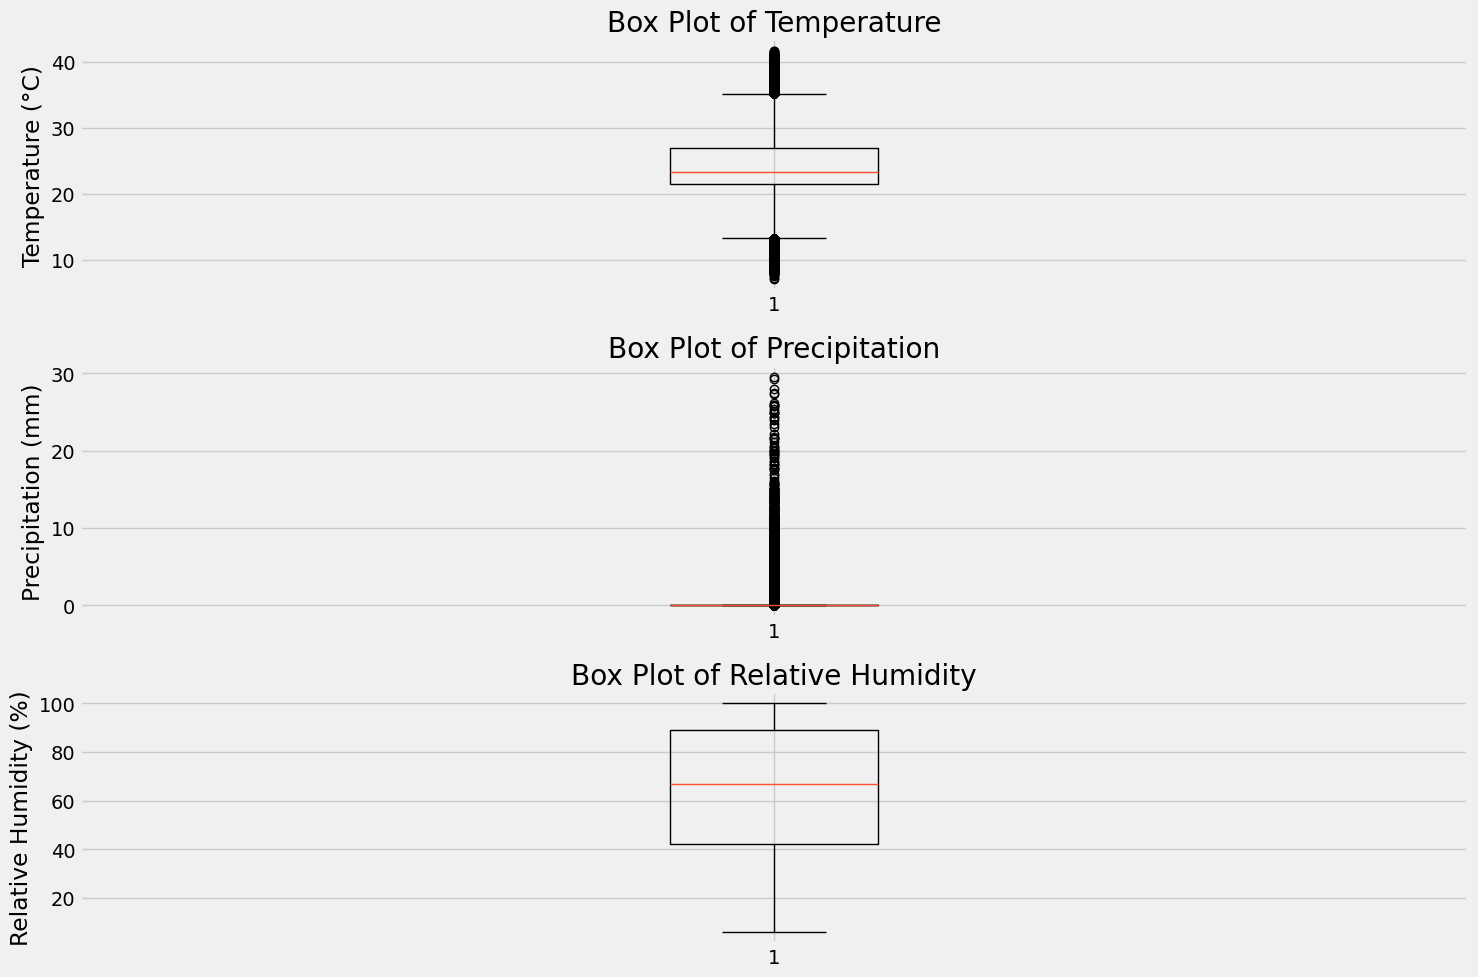

In [7]:
plt.figure(figsize=(15, 10))
#boxplots to see if there the seasonal outliers
plt.subplot(3, 1, 1)
plt.boxplot(weather_data['temperature'])
plt.title('Box Plot of Temperature')
plt.ylabel('Temperature (°C)')

plt.subplot(3, 1, 2)
plt.boxplot(weather_data['precipitation (mm)'])
plt.title('Box Plot of Precipitation')
plt.ylabel('Precipitation (mm)')

plt.subplot(3, 1, 3)
plt.boxplot(weather_data['relative_humidity'])
plt.title('Box Plot of Relative Humidity')
plt.ylabel('Relative Humidity (%)')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [8]:
#New Time features
weather_data['year'] = weather_data['time'].dt.year
weather_data['month'] = weather_data['time'].dt.month
weather_data['day'] = weather_data['time'].dt.day
weather_data['hour'] = weather_data['time'].dt.hour
weather_data['day_of_week'] = weather_data['time'].dt.dayofweek

# Display the first few rows to verify the new features
weather_data[['time', 'month', 'day', 'hour', 'day_of_week']].head()

,time,month,day,hour,day_of_week
0,1980-01-01 00:00:00,1,1,0,1
1,1980-01-01 01:00:00,1,1,1,1
2,1980-01-01 02:00:00,1,1,2,1
3,1980-01-01 03:00:00,1,1,3,1
4,1980-01-01 04:00:00,1,1,4,1


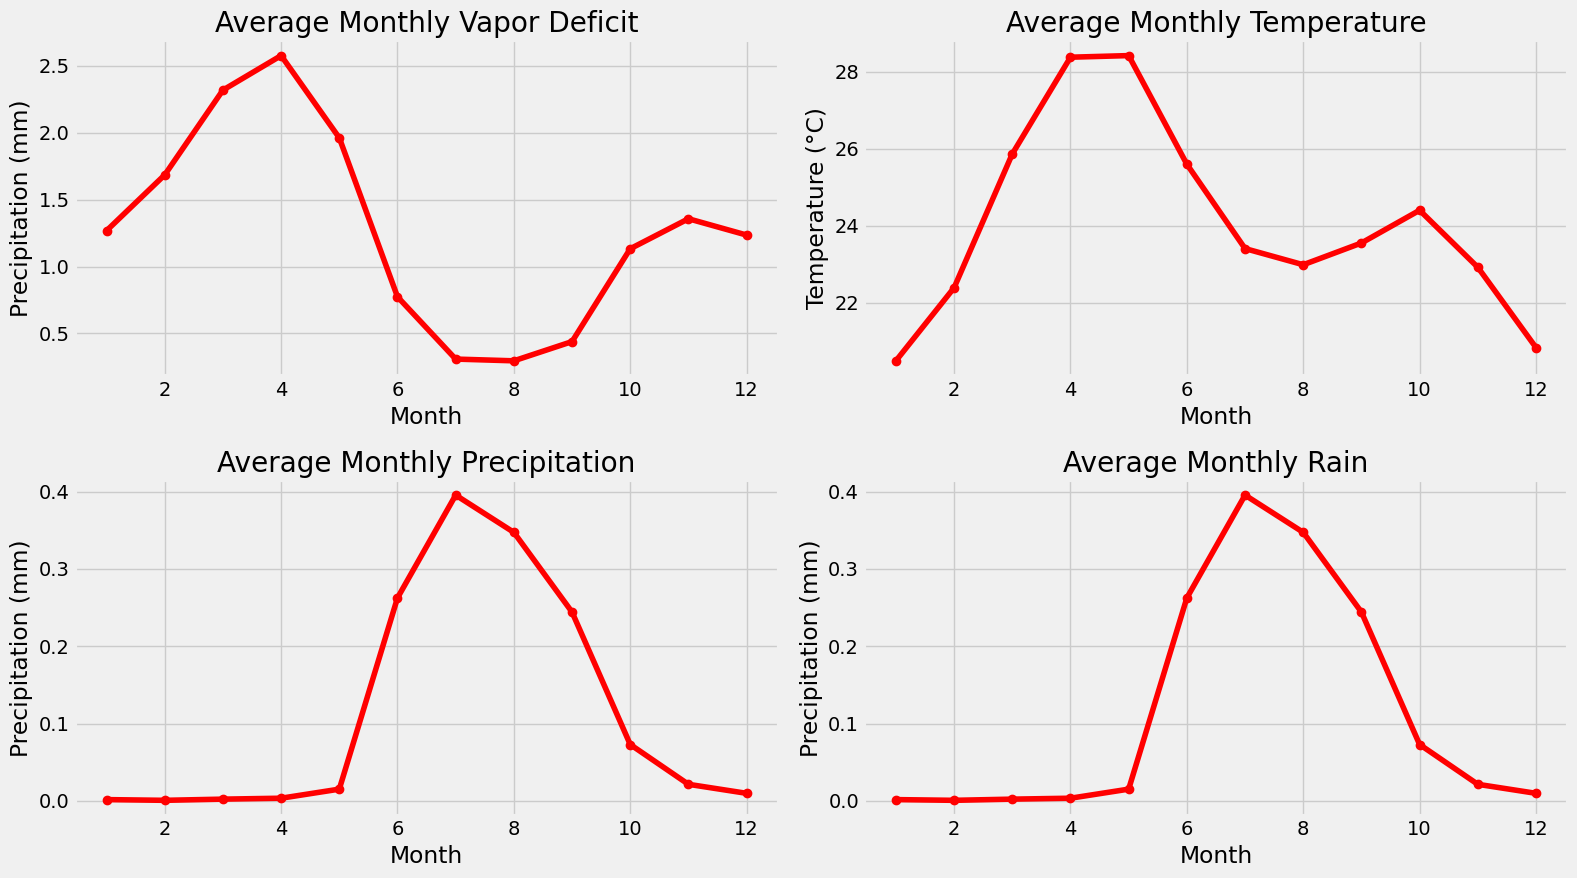

In [9]:
# Calculate the average monthly temperature and precipitation
monthly_avg = weather_data.groupby('month').agg({
    'temperature': 'mean',
    'precipitation (mm)': 'mean',
    'rain (mm)':'mean',
    'vapour_pressure_deficit (kPa)': 'mean'

}).reset_index()

# Set the figure size for better visibility
plt.figure(figsize=(16,9 ))

# Plot average monthly vapour deficit
plt.subplot(2, 2, 1)
plt.plot(monthly_avg['month'], monthly_avg['vapour_pressure_deficit (kPa)'], marker='o', color='red')
plt.title('Average Monthly Vapor Deficit')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
# Plot average monthly temperatue
plt.subplot(2, 2, 2)
plt.plot(monthly_avg['month'], monthly_avg['temperature'], marker='o', color='red')
plt.title('Average Monthly Temperature')
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.grid(True)
#Average monthly precipitation
plt.subplot(2,2,3)
plt.plot(monthly_avg['month'], monthly_avg['precipitation (mm)'], marker='o', color='red')
plt.title('Average Monthly Precipitation')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.grid(True)

#avarage monthly rain
plt.subplot(2,2,4)
plt.plot(monthly_avg['month'], monthly_avg['rain (mm)'], marker='o', color='red')
plt.title('Average Monthly Rain')
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

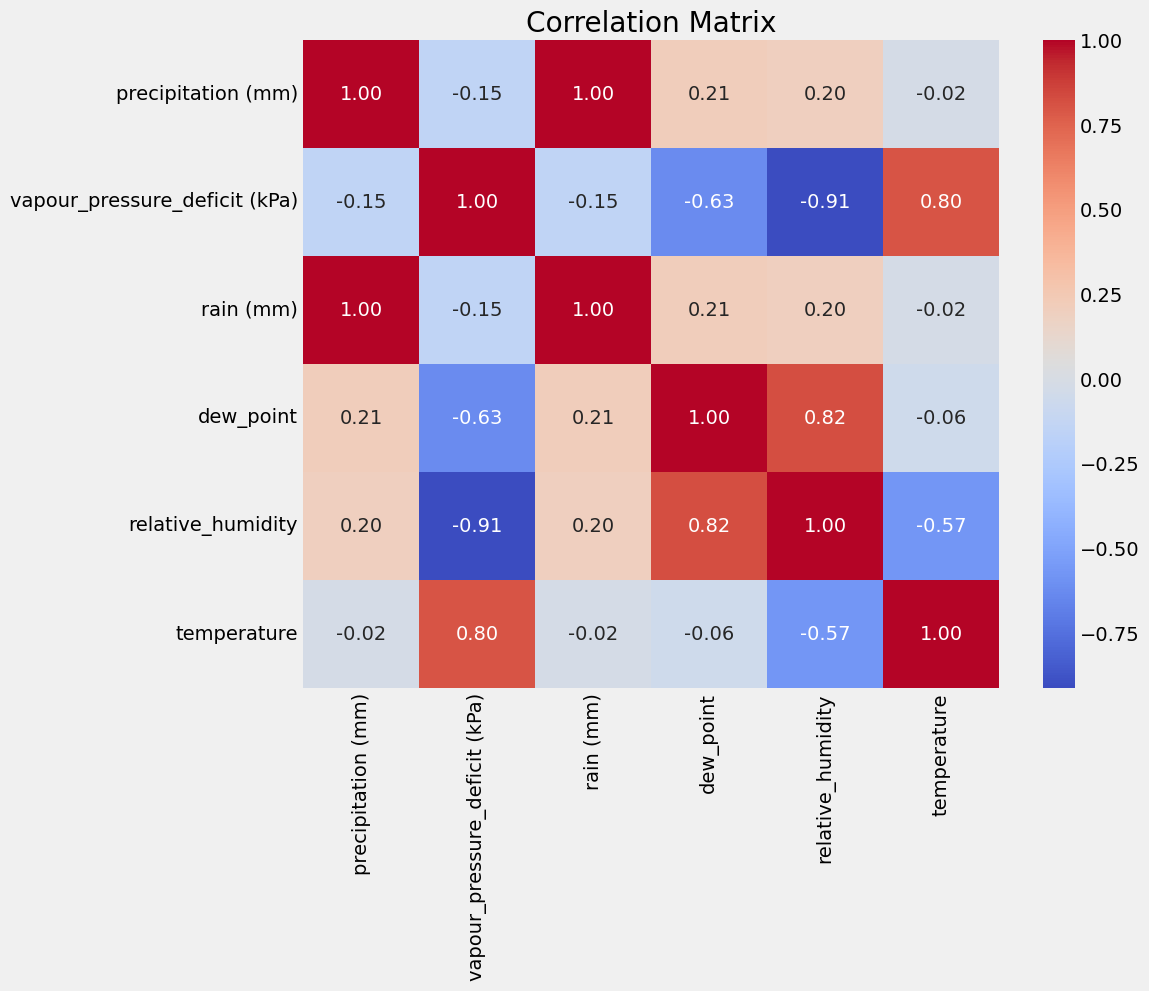

In [10]:
corr_matrix = weather_data[['precipitation (mm)','vapour_pressure_deficit (kPa)','rain (mm)','dew_point','relative_humidity','temperature']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

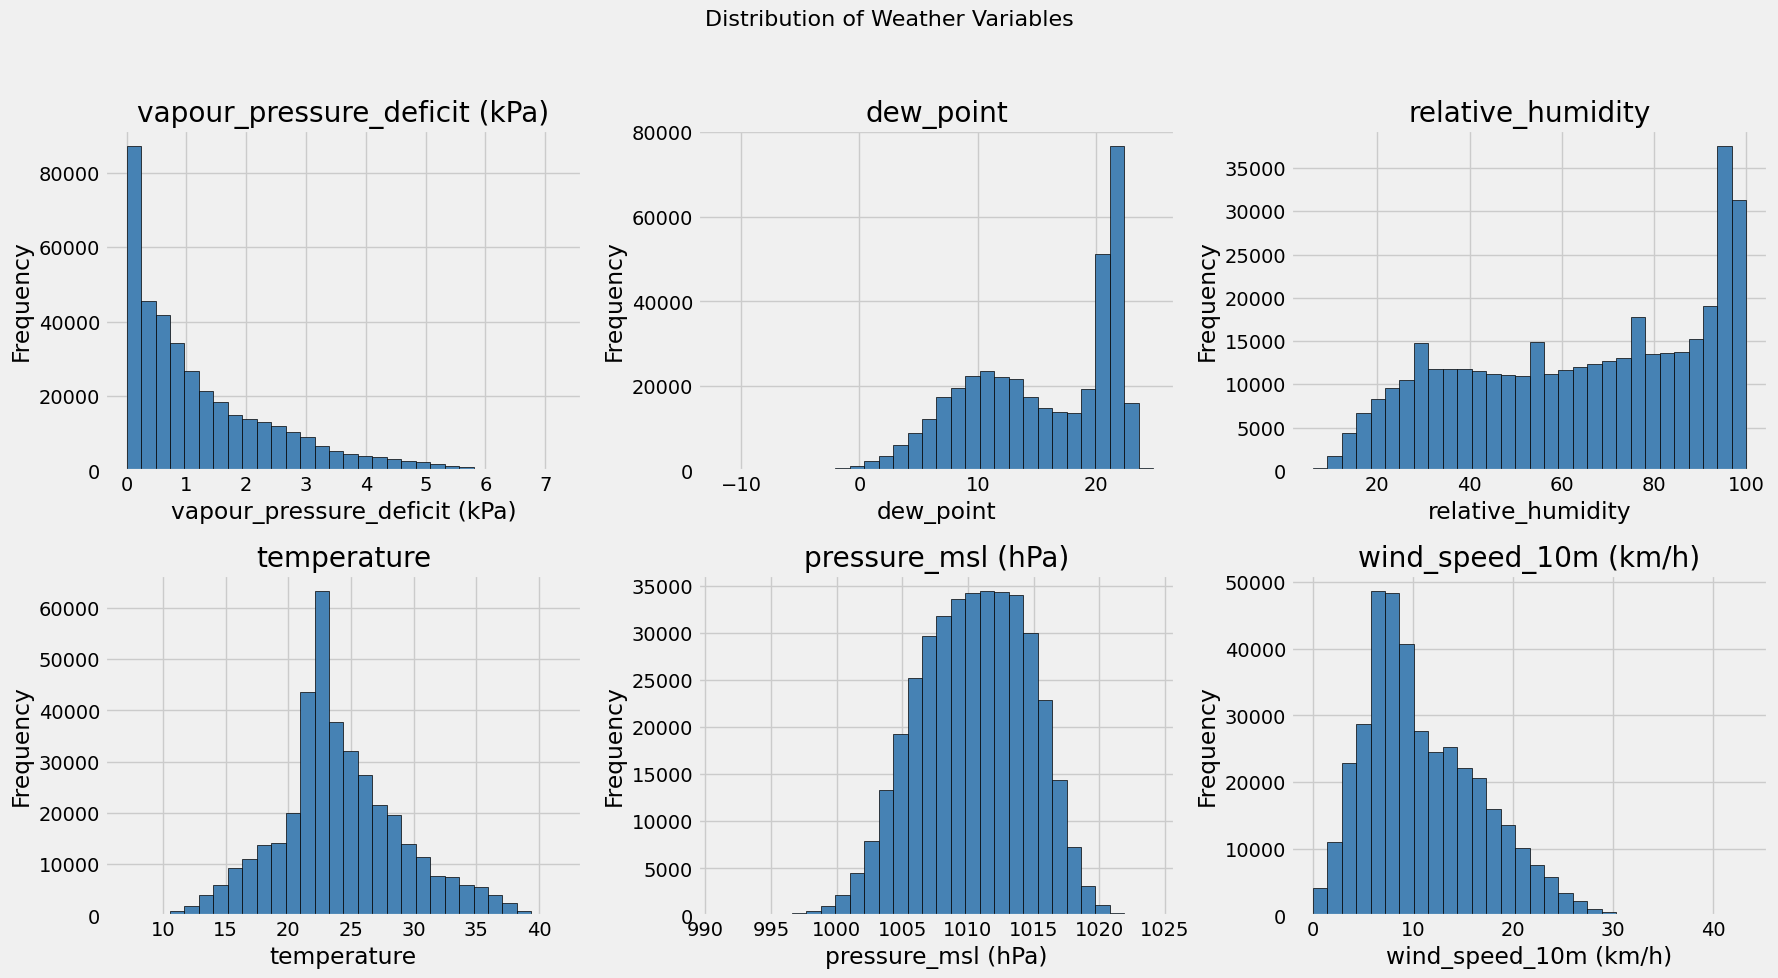

In [11]:
# Define figure and grid size
fig, axes = plt.subplots(3, 3, figsize=(18, 14))
fig.suptitle('Distribution of Weather Variables', fontsize=16)

# Define variables to plot and their corresponding titles
variables = ['vapour_pressure_deficit (kPa)','dew_point','relative_humidity','temperature','pressure_msl (hPa)','wind_speed_10m (km/h)']
titles = ['vapour_pressure_deficit (kPa)','dew_point','relative_humidity','temperature','pressure_msl (hPa)','wind_speed_10m (km/h)']

# Loop through variables and plot them
for i, ax in enumerate(axes.flatten()):
    if i < len(variables):
        weather_data[variables[i]].hist(ax=ax, bins=30, color='steelblue', edgecolor='black')
        ax.set_title(titles[i])
        ax.set_xlabel(f'{titles[i]}')
        ax.set_ylabel('Frequency')
    else:
        fig.delaxes(ax)  # Remove empty subplots

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to make room for the suptitle
plt.show()

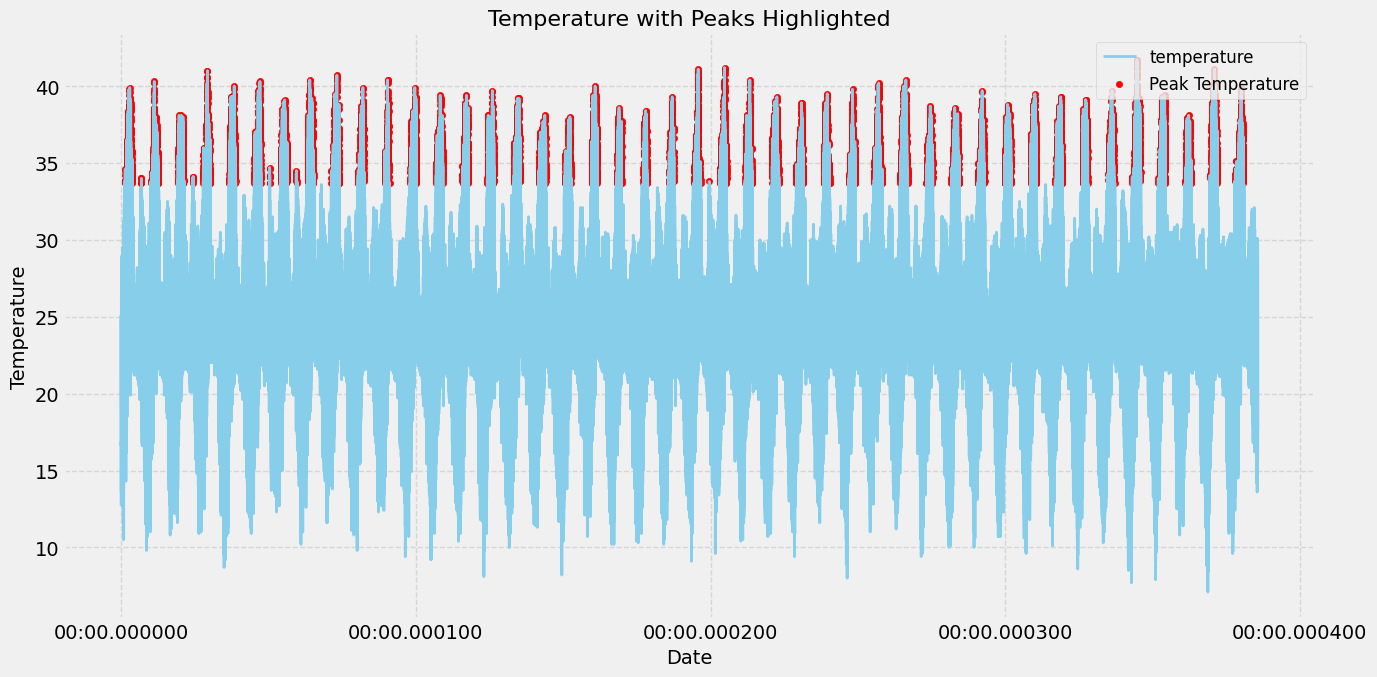

In [12]:
# Ensure the datetime index is correctly formatted
weather_data.index = pd.to_datetime(weather_data.index)

# Calculate peak consumption based on a quantile threshold
weather_data['peak_temperature'] = weather_data['temperature'] > weather_data['temperature'].quantile(0.95)

plt.figure(figsize=(14, 7))
plt.plot(weather_data.index, weather_data['temperature'], label='temperature', color='skyblue', linewidth=2)
plt.scatter(weather_data[weather_data['peak_temperature']].index, weather_data[weather_data['peak_temperature']]['temperature'], color='red', s=20, label='Peak Temperature')

# Add title and labels
plt.title('Temperature with Peaks Highlighted', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Temperature', fontsize=14)

# Add grid lines for clarity
plt.grid(True, linestyle='--', alpha=0.7)

# Enhance legend and layout
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()

plt.show()

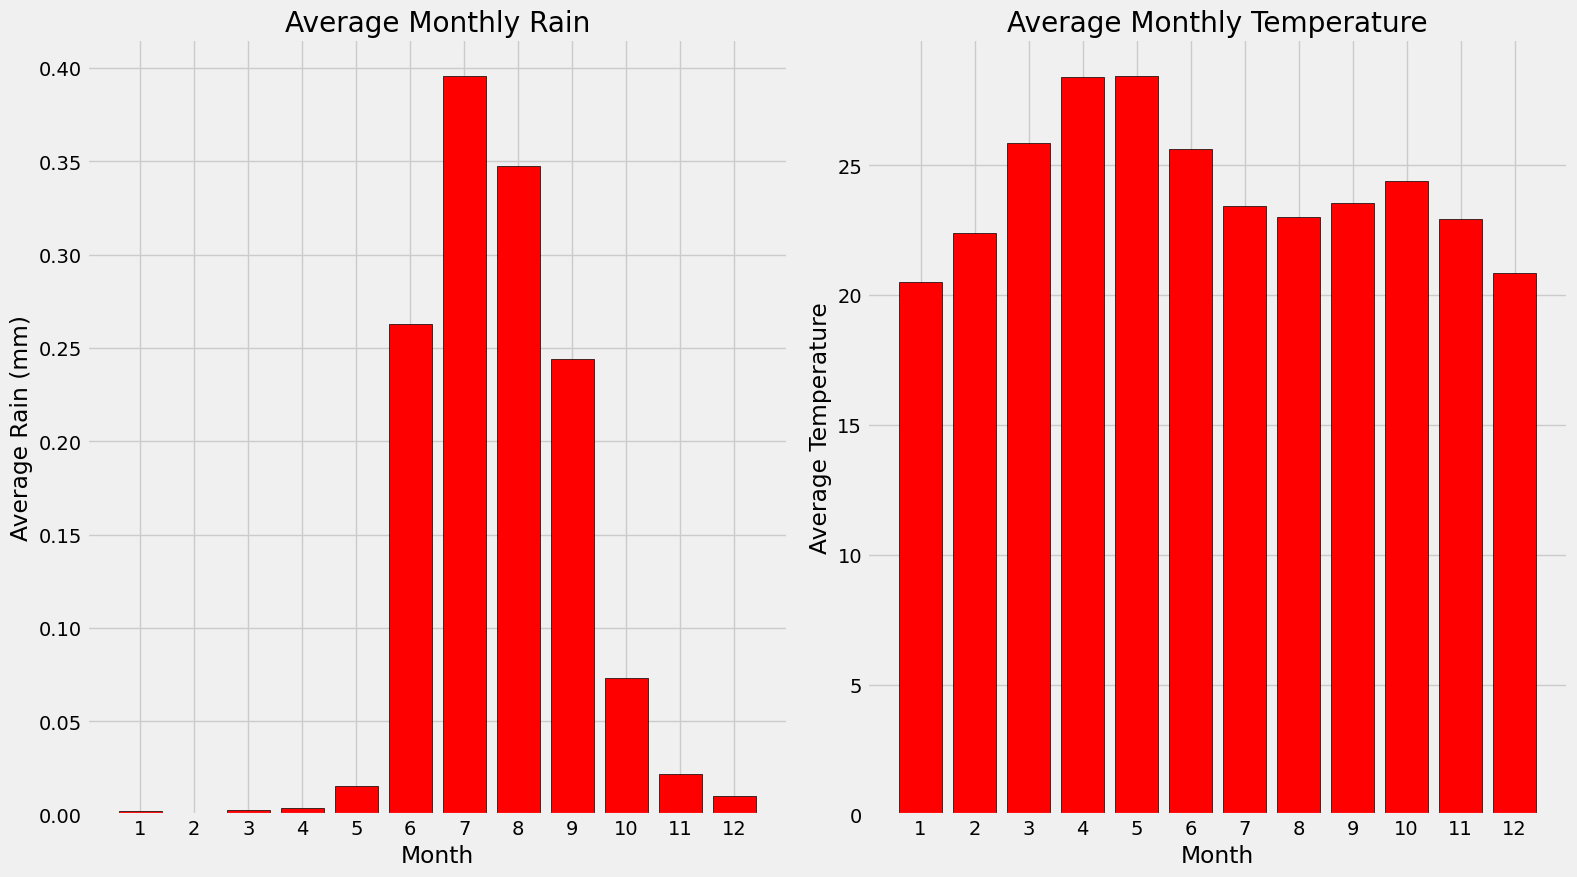

In [13]:
# Assuming monthly_avg DataFrame is already defined with the average monthly data
# Extracting data for the plot
months = monthly_avg['month']
avg_rain = monthly_avg['rain (mm)']
avg_temperature = monthly_avg['temperature']

plt.figure(figsize=(16, 9))
plt.subplot(1,2,1)
# Plotting the bar chart
plt.bar(months, avg_rain, color='red', edgecolor='black')
# Adding titles and labels
plt.title('Average Monthly Rain')
plt.xlabel('Month')
plt.ylabel('Average Rain (mm)')
plt.xticks(months)  #

# Display the plot
plt.grid(True)
plt.subplot(1,2,2)
plt.bar(months,avg_temperature,color='Red',edgecolor='black')

# Adding titles and labels
plt.title('Average Monthly Temperature')
plt.xlabel('Month')
plt.ylabel('Average Temperature')
plt.xticks(months)  #
plt.grid(True)
plt.tight_layout()
plt.show()

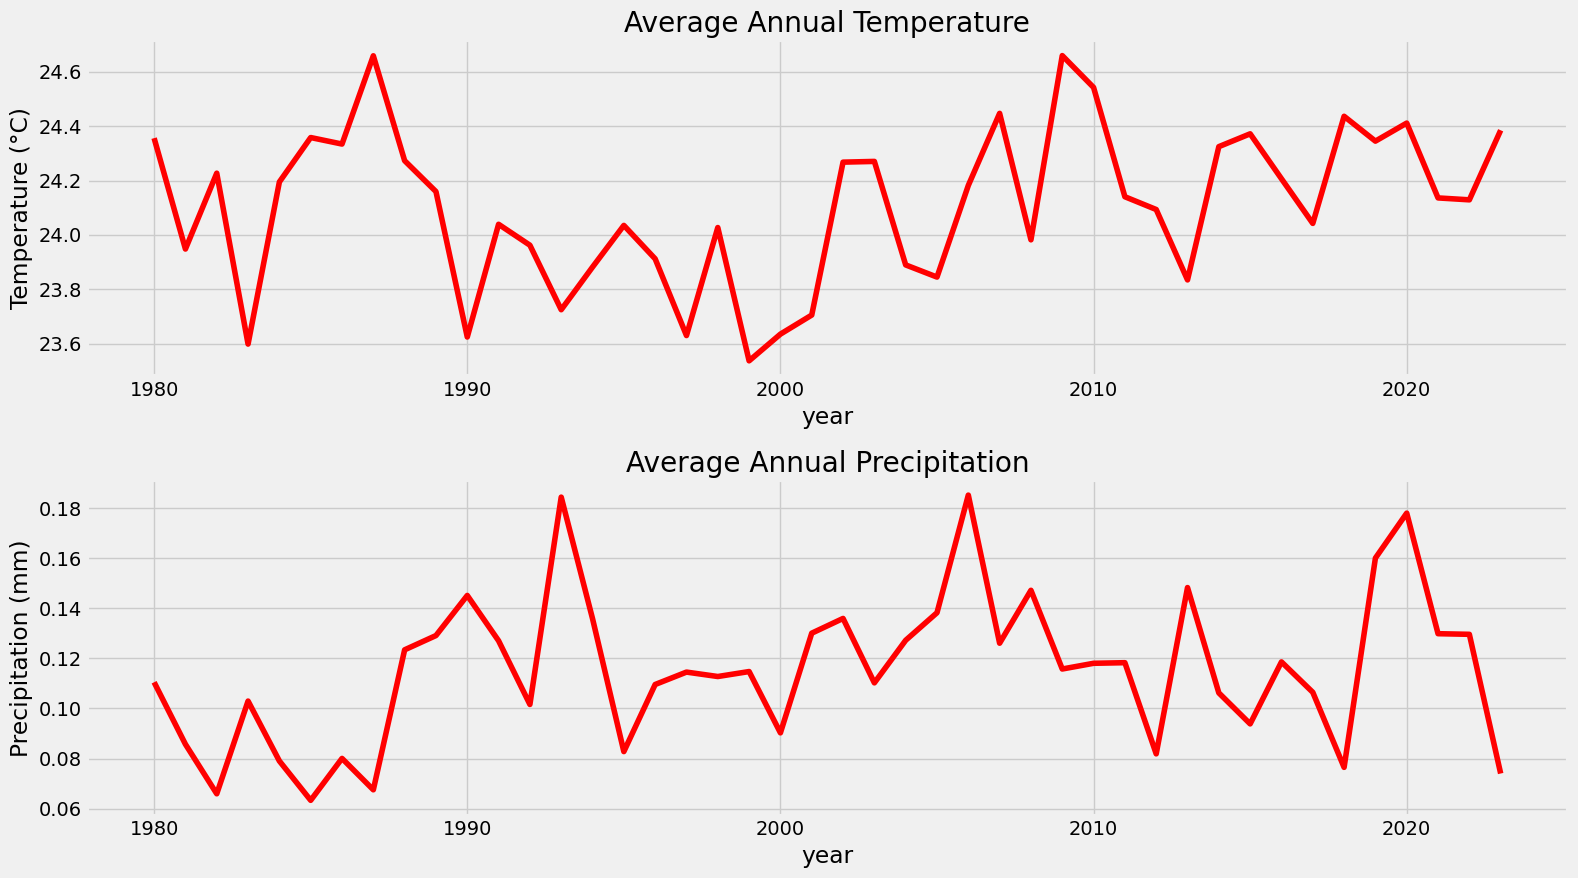

In [14]:
#Temperatue and Rain over the years
yearly_avg = weather_data.groupby('year').agg({
    'temperature': 'mean',
    'precipitation (mm)': 'mean',
    'rain (mm)':'mean',
    'vapour_pressure_deficit (kPa)':'mean'
}).reset_index()
plt.figure(figsize=(16,9))
# Plot average monthly temperature
plt.subplot(2, 1, 1)
plt.plot(yearly_avg['year'], yearly_avg['temperature'], color='red')
plt.title('Average Annual Temperature')
plt.xlabel('year')
plt.ylabel('Temperature (°C)')
plt.grid(True)

# Plot average monthly precipitation
plt.subplot(2, 1, 2)
plt.plot(yearly_avg['year'], yearly_avg['precipitation (mm)'], color='red')
plt.title('Average Annual Precipitation')
plt.xlabel('year')
plt.ylabel('Precipitation (mm)')
plt.grid(True)
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

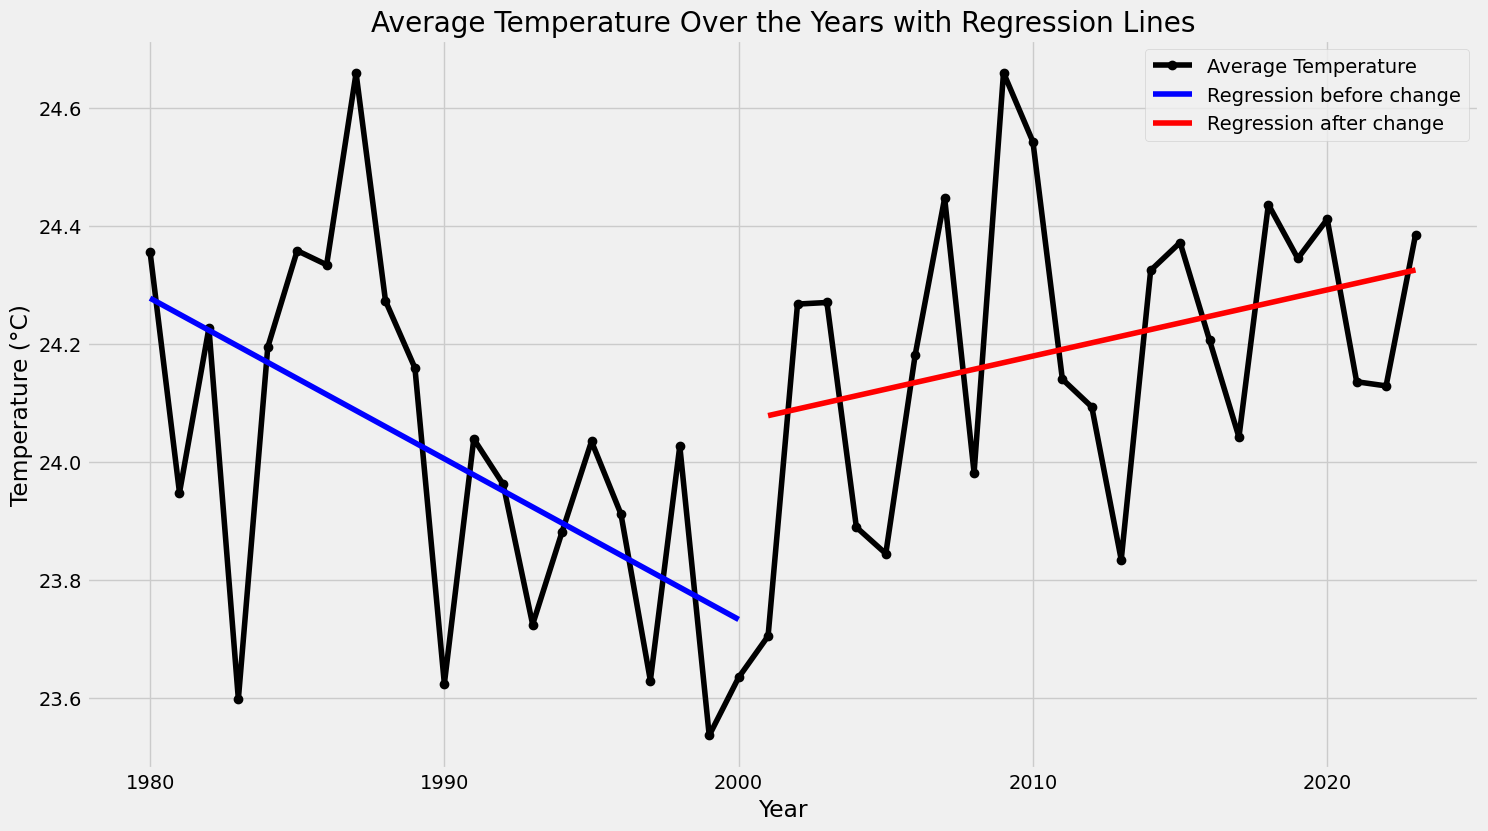

In [15]:
# Assuming you have yearly_avg DataFrame with 'year' and 'temperature' columns
plt.figure(figsize=(16,9))
# Scatter plot of average temperature over the years
plt.plot(yearly_avg['year'], yearly_avg['temperature'], label='Average Temperature',marker = 'o', color='black')
# Fit linear regression model
model = LinearRegression()

# Segment the data into two parts: before and after a change point
change_point_year = 2000  # Change this value based on your data
before_change = yearly_avg[yearly_avg['year'] <= change_point_year]
after_change = yearly_avg[yearly_avg['year'] > change_point_year]

# Fit separate regression lines for each segment
model.fit(before_change[['year']], before_change['temperature'])
plt.plot(before_change['year'], model.predict(before_change[['year']]), color='blue', linestyle='-', label='Regression before change')

model.fit(after_change[['year']], after_change['temperature'])
plt.plot(after_change['year'], model.predict(after_change[['year']]), color='red', linestyle='-', label='Regression after change')

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.title('Average Temperature Over the Years with Regression Lines')

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

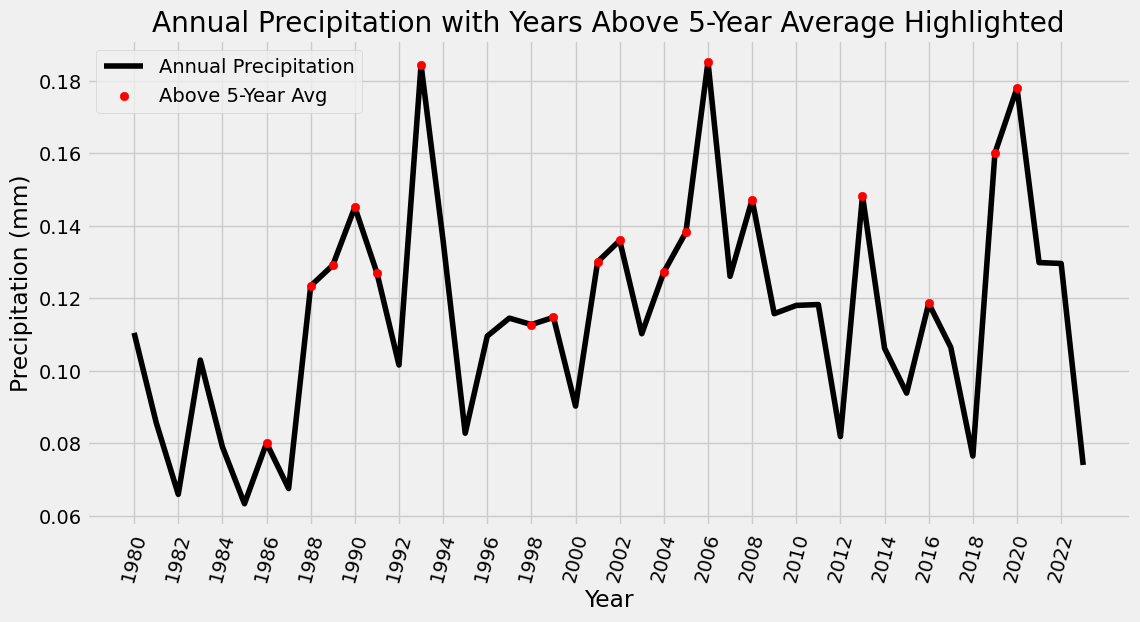

In [16]:
# Calculate the rolling average of the past 2 years
yearly_avg['5_year_avg'] = yearly_avg['precipitation (mm)'].rolling(window=5).mean()

# Identify years where precipitation exceeds the 5-year rolling average
peak_data = yearly_avg[yearly_avg['precipitation (mm)'] > yearly_avg['5_year_avg']]

# Plot annual precipitation
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg['year'], yearly_avg['precipitation (mm)'], label='Annual Precipitation', color='black')

# Highlight peak years where precipitation exceeds 5-year average
plt.scatter(peak_data['year'], peak_data['precipitation (mm)'], color='red', label='Above 5-Year Avg', zorder=5)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Precipitation (mm)')
plt.title('Annual Precipitation with Years Above 5-Year Average Highlighted')
plt.xticks(rotation=75)

# Set x-axis ticks at an interval of 2 years
plt.xticks(ticks=range(yearly_avg['year'].min(), yearly_avg['year'].max() + 1, 2))

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

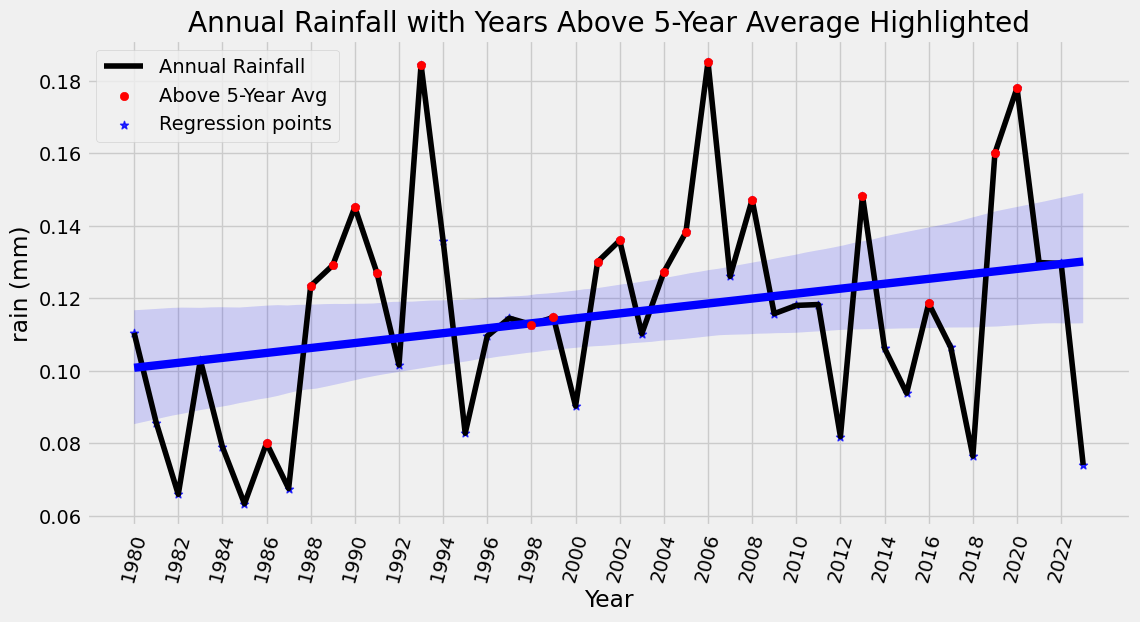

In [17]:
# Calculate the rolling average of the past 2 years
yearly_avg['5_year_avg_rain'] = yearly_avg['rain (mm)'].rolling(window=5).mean()

# Identify years where precipitation exceeds the 5-year rolling average
peak_data = yearly_avg[yearly_avg['rain (mm)'] > yearly_avg['5_year_avg_rain']]

# Plot annual precipitation
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg['year'], yearly_avg['rain (mm)'], label='Annual Rainfall', color='black')

# Highlight peak years where precipitation exceeds 5-year average
plt.scatter(peak_data['year'], peak_data['rain (mm)'], color='red', label='Above 5-Year Avg', zorder=5)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Rain (mm)')
plt.title('Annual Rainfall with Years Above 5-Year Average Highlighted')
plt.xticks(rotation=75)
sns.regplot(x=list(set(weather_data['year'])),y=yearly_avg['rain (mm)'],color='blue',marker='*',label='Regression points')

# Set x-axis ticks at an interval of 2 years
plt.xticks(ticks=range(yearly_avg['year'].min(), yearly_avg['year'].max() + 1, 2))

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()

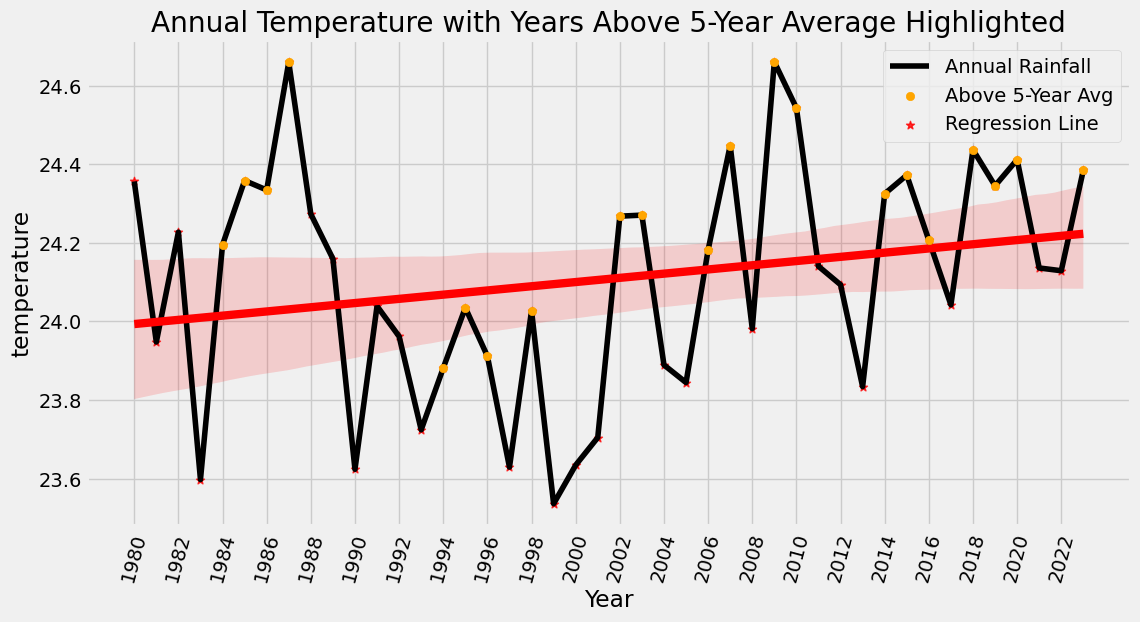

In [18]:
# Calculate the rolling average of the past 2 years
yearly_avg['2_year_avg_temp'] = yearly_avg['temperature'].rolling(window=5).mean()

# Identify years where precipitation exceeds the 5-year rolling average
peak_data = yearly_avg[yearly_avg['temperature'] > yearly_avg['2_year_avg_temp']]

# Plot annual precipitation
plt.figure(figsize=(12, 6))
plt.plot(yearly_avg['year'], yearly_avg['temperature'], label='Annual Rainfall', color='black')

# Highlighting peak years where precipitation exceeds 5-year average
plt.scatter(peak_data['year'], peak_data['temperature'], color='orange', label='Above 5-Year Avg', zorder=5)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Temperature')
plt.xticks(rotation=75)
plt.title('Annual Temperature with Years Above 5-Year Average Highlighted')

# Set x-axis ticks at an interval of 2 years
plt.xticks(ticks=range(yearly_avg['year'].min(), yearly_avg['year'].max() + 1, 2))
sns.regplot(x=list(set(weather_data['year'])),y=yearly_avg['temperature'],color='red',marker="*",fit_reg=True,label='Regression Line')
# Add legend
plt.legend()
# Show plot
plt.grid(True)
plt.show()

In [19]:
features = ['temperature', 'precipitation (mm)', 'relative_humidity']  # Add more features if needed
target = 'temperature'

In [20]:
X = weather_data[features]
y = weather_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [21]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)  # Adjust hyperparameters as needed
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [22]:
y_pred = model.predict(X_test)

In [23]:
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.10333525490219575


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


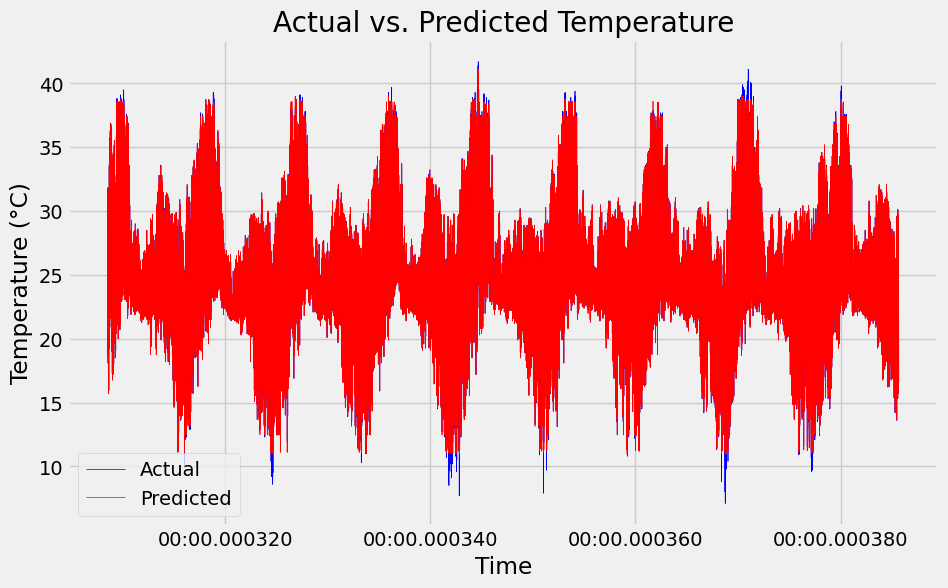

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index, y_test.values, label='Actual', color='blue', linewidth=0.5)  # Actual values
plt.plot(y_test.index, y_pred, label='Predicted', color='red', linewidth=0.5)    # Predicted values
plt.title('Actual vs. Predicted Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In [25]:
future_dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='H')
future_data = pd.DataFrame({'time': future_dates})

<ipython-input-25-6966d1892630>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  future_dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='H')


In [26]:
future_data['year'] = future_data['time'].dt.year
future_data['month'] = future_data['time'].dt.month
future_data['day'] = future_data['time'].dt.day
future_data['hour'] = future_data['time'].dt.hour
future_data['day_of_week'] = future_data['time'].dt.dayofweek

In [27]:
features = ['year', 'month', 'day', 'hour', 'day_of_week']  # Features for prediction
targets = ['temperature']  # Targets to predict

In [28]:
X = weather_data[features]
y = weather_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [29]:
model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, objective='reg:squarederror')

In [30]:
model.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [31]:
X_future = future_data[features]

In [32]:
future_predictions = model.predict(X_future)

In [33]:
predictions_df = pd.DataFrame(future_predictions, columns=targets, index=future_data.index)

In [34]:
future_data = future_data.drop(columns=['year', 'month', 'day', 'hour', 'day_of_week'])

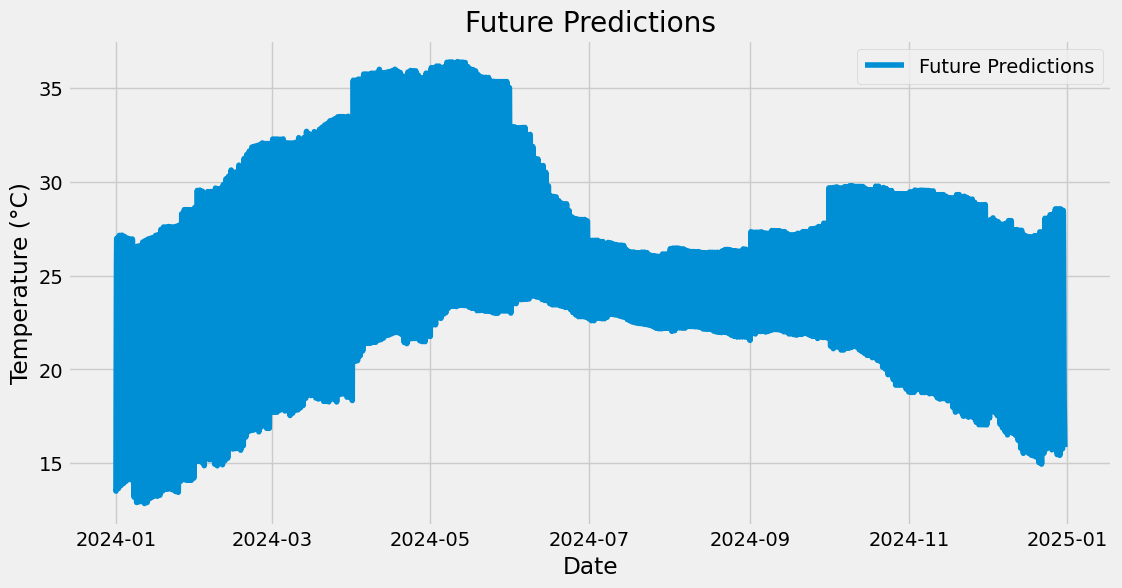

In [35]:
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.plot(future_data['time'], predictions_df[targets[0]], label='Future Predictions')
# Replace 'targets[0]' with the actual column name if different
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Future Predictions')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
actual_df = pd.read_csv('/content/Weather_Data_1980_2024(hourly).csv', index_col=0, parse_dates=True)

In [37]:
actual_temp = actual_df.iloc[:, 0]

In [38]:
start_date = '2022-01-01'
end_date = '2023-12-31'
actual_temp_filtered = actual_temp[(actual_temp.index >= start_date) & (actual_temp.index <= end_date)]

In [39]:
temp_predictions_df = pd.DataFrame({'time': future_data['time'], 'temp': predictions_df[targets[0]]})
extended_df = pd.concat([actual_temp_filtered, temp_predictions_df])

Text(0, 0.5, 'Temperature (°C)')

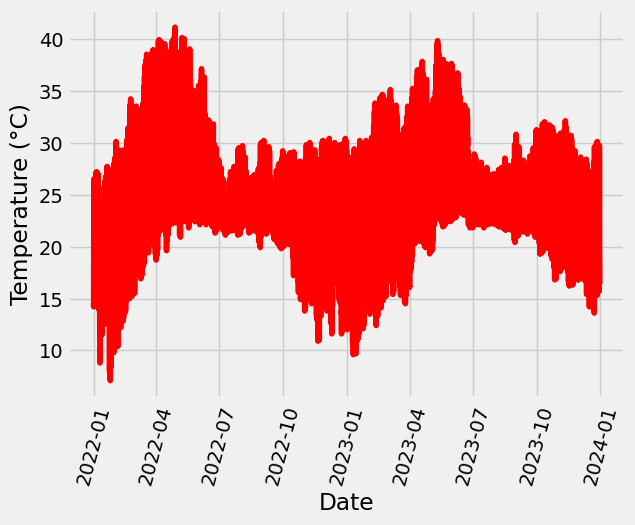

In [40]:
plt.plot(actual_temp_filtered.index, actual_temp_filtered.values, label='Actual Temperature', color='red')
plt.xticks(rotation=75)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')

Text(0, 0.5, 'Temperature (°C)')

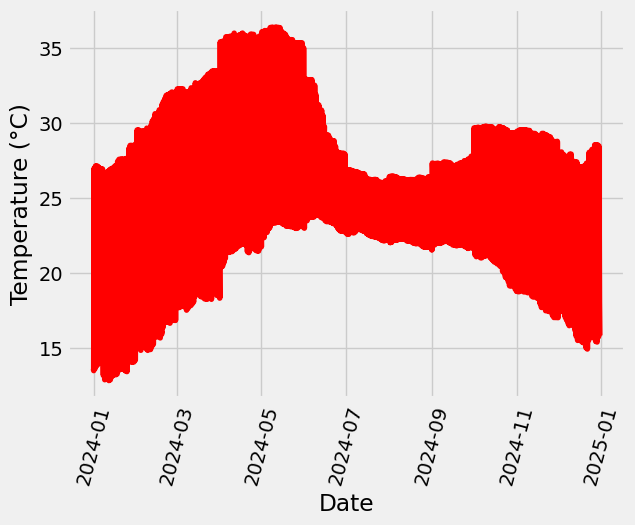

In [41]:
plt.plot(future_data['time'], predictions_df.values, label='Predicted Temperature', color='red')
plt.xticks(rotation=75)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')

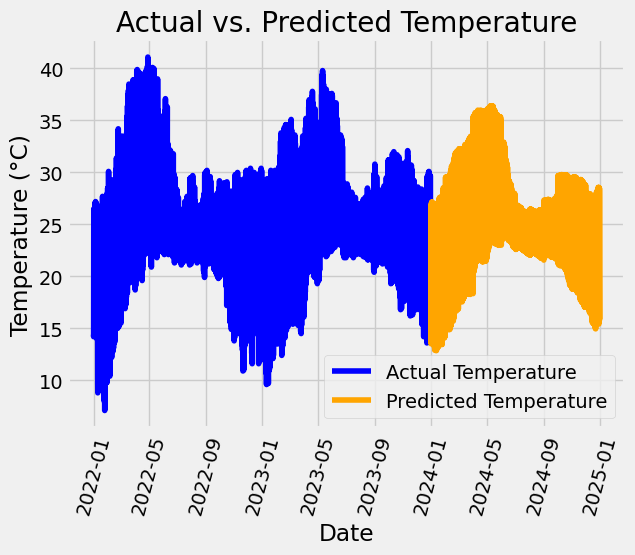

In [42]:
# Plot actual temperature
plt.plot(actual_temp_filtered.index, actual_temp_filtered.values, label='Actual Temperature', color='blue')

# Plot predicted temperature (extended)
plt.plot(future_data['time'], predictions_df.values, label='Predicted Temperature', color='orange')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Actual vs. Predicted Temperature')
plt.legend()

# Show the plot
plt.xticks(rotation=75)
plt.show()

In [43]:
weather_data['quarter'] = weather_data['time'].dt.quarter
weather_data['day_of_year'] = weather_data['time'].dt.dayofyear
X = weather_data[['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year']]
y = weather_data['relative_humidity']

In [44]:
X.shape

(385680, 6)

In [45]:
y.shape


(385680,)

In [46]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [47]:
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []

    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 24

X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LENGTH)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

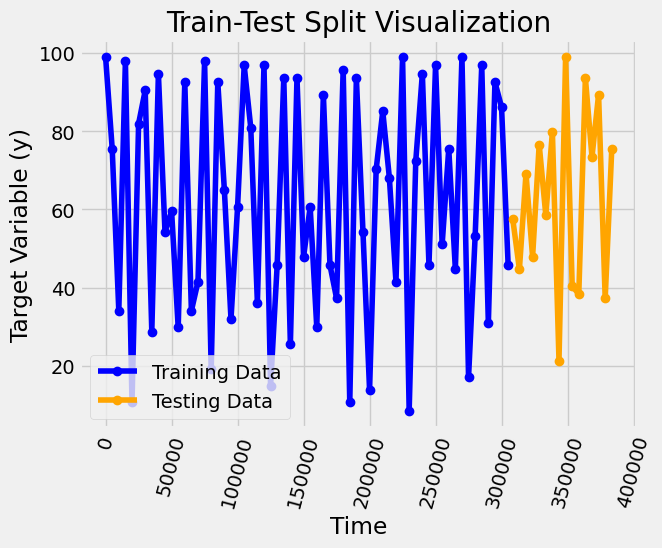

In [49]:
total_len = len(X_seq)
time_index = range(total_len)
test_start_index = total_len - len(X_test)

x_indices = np.arange(0, total_len, 5000)

x_indices_train = x_indices[x_indices < len(y_train)]  # Indices for y_train
x_indices_test = x_indices[x_indices < len(y_test)]  # Indices for y_test

y_train_sampled = y_train[x_indices_train] * 100  # Select y_train values using valid indices
y_test_sampled = y_test[x_indices_test] * 100  # Select y_test values using valid indices


plt.plot(x_indices_train, y_train_sampled, label='Training Data', color='blue', marker='o', linestyle='-')
plt.plot(x_indices_test + test_start_index, y_test_sampled, label='Testing Data', color='orange', marker='o', linestyle='-')  # Shift x_indices_test for plotting


plt.xlabel('Time')
plt.ylabel('Target Variable (y)')
plt.title('Train-Test Split Visualization')
plt.legend()
plt.xticks(rotation=75)

plt.show()


In [50]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dropout, Dense


model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_rnn.add(Dropout(0.2))
model_rnn.add(SimpleRNN(units=50))
model_rnn.add(Dropout(0.2))

model_rnn.add(Dense(units=2))

model_rnn.compile(optimizer='adam', loss='mean_squared_error')

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 24, 50)            2850      
                                                                 
 dropout (Dropout)           (None, 24, 50)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 8002 (31.26 KB)
Trainable params: 8002 (31.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
hist = model_rnn.fit(X_train, y_train,
                     epochs=50, batch_size=32,
                     validation_data=(X_test, y_test))

Epoch 1/50
9642/9642 [==============================] - 96s 10ms/step - loss: 0.0234 - val_loss: 0.0176
Epoch 2/50
9642/9642 [==============================] - 95s 10ms/step - loss: 0.0157 - val_loss: 0.0168
Epoch 3/50
9642/9642 [==============================] - 94s 10ms/step - loss: 0.0153 - val_loss: 0.0159
Epoch 4/50
9642/9642 [==============================] - 96s 10ms/step - loss: 0.0151 - val_loss: 0.0167
Epoch 5/50
9642/9642 [==============================] - 96s 10ms/step - loss: 0.0149 - val_loss: 0.0168
Epoch 6/50
9642/9642 [==============================] - 98s 10ms/step - loss: 0.0148 - val_loss: 0.0175
Epoch 7/50
9642/9642 [==============================] - 97s 10ms/step - loss: 0.0147 - val_loss: 0.0156
Epoch 8/50
9642/9642 [==============================] - 96s 10ms/step - loss: 0.0147 - val_loss: 0.0147
Epoch 9/50
9642/9642 [==============================] - 95s 10ms/step - loss: 0.0147 - val_loss: 0.0158
Epoch 10/50
9642/9642 [==============================] - 94s 10m

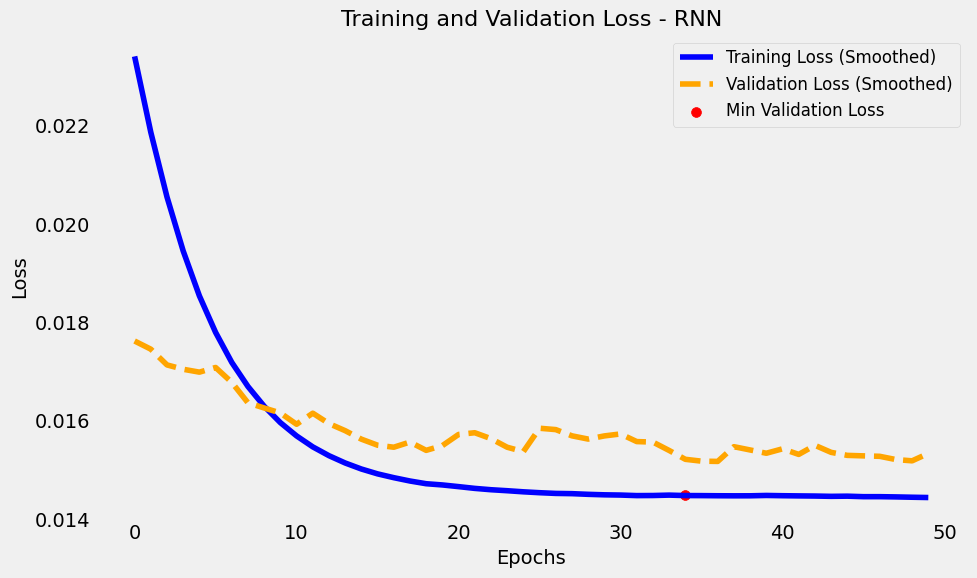

In [52]:
# Function to smooth the curve
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting the training and validation loss with improvements
plt.figure(figsize=(10, 6))

# Smoothed loss curves
smoothed_training_loss = smooth_curve(hist.history['loss'])
smoothed_validation_loss = smooth_curve(hist.history['val_loss'])

# Plot the smoothed training and validation loss
plt.plot(smoothed_training_loss, label='Training Loss (Smoothed)', color='blue', linestyle='-')
plt.plot(smoothed_validation_loss, label='Validation Loss (Smoothed)', color='orange', linestyle='--')

# Highlight minimum validation loss
min_val_loss_idx = np.argmin(hist.history['val_loss'])
plt.scatter(min_val_loss_idx, hist.history['val_loss'][min_val_loss_idx], color='red', s=50, label='Min Validation Loss')

# Adding grid lines
plt.grid(False)

# Titles and labels
plt.title('Training and Validation Loss - RNN', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Adding a legend
plt.legend(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [53]:
y_pred_rnn = model_rnn.predict(X_test)

2411/2411 [==============================] - 9s 3ms/step


In [54]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
model_lstm = Sequential()
model_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=2))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 50)            11400     
                                                                 
 dropout_2 (Dropout)         (None, 24, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 102       
                                                                 
Total params: 31702 (123.84 KB)
Trainable params: 31702 (123.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
hist_2 = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
9642/9642 [==============================] - 182s 19ms/step - loss: 0.0176 - val_loss: 0.0149
Epoch 2/50
9642/9642 [==============================] - 183s 19ms/step - loss: 0.0147 - val_loss: 0.0155
Epoch 3/50
9642/9642 [==============================] - 189s 20ms/step - loss: 0.0144 - val_loss: 0.0147
Epoch 4/50
9642/9642 [==============================] - 170s 18ms/step - loss: 0.0143 - val_loss: 0.0147
Epoch 5/50
9642/9642 [==============================] - 173s 18ms/step - loss: 0.0142 - val_loss: 0.0154
Epoch 6/50
9642/9642 [==============================] - 185s 19ms/step - loss: 0.0141 - val_loss: 0.0152
Epoch 7/50
9642/9642 [==============================] - 181s 19ms/step - loss: 0.0140 - val_loss: 0.0159
Epoch 8/50
9642/9642 [==============================] - 179s 19ms/step - loss: 0.0139 - val_loss: 0.0149
Epoch 9/50
9642/9642 [==============================] - 182s 19ms/step - loss: 0.0138 - val_loss: 0.0148
Epoch 10/50
9642/9642 [==============================] 

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plotting the training and validation loss with improvements
plt.figure(figsize=(10, 6))

# Smooth the curves (optional)
smoothed_training_loss = smooth_curve(hist_2.history['loss'])
smoothed_validation_loss = smooth_curve(hist_2.history['val_loss'])

# Plot the training loss
plt.plot(smoothed_training_loss, label='Training Loss', color='blue', linestyle='-', linewidth=2)
# Plot the validation loss
plt.plot(smoothed_validation_loss, label='Validation Loss', color='orange', linestyle='--', linewidth=2)

# Highlight minimum validation loss
min_val_loss_idx = np.argmin(hist_2.history['val_loss'])
plt.scatter(min_val_loss_idx, hist_2.history['val_loss'][min_val_loss_idx], color='red', s=50, label='Min Validation Loss')

# Adding grid lines
plt.grid(True, linestyle='--', alpha=0.6)

# Titles and labels
plt.title('Training and Validation Loss Over Epochs - LSTM', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Adding a legend
plt.legend(fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
y_pred_lstm = model_lstm.predict(X_test)

In [ ]:
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=False)

In [ ]:
y_test_descaled = scaler_y.inverse_transform(y_test)
y_pred_rnn_descaled = scaler_y.inverse_transform(y_pred_rnn)
y_pred_lstm_descaled = scaler_y.inverse_transform(y_pred_lstm)

In [ ]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
plt.plot(y_test_descaled[:1000], color='blue', label='Real Consumption', linewidth=2)
plt.plot(y_pred_rnn_descaled[:1000], color='red', linestyle='dashed', label='RNN Predicted Consumption', linewidth=2)
plt.title('Real vs RNN Predicted Consumption', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('MW', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Subplot for LSTM
plt.subplot(2, 1, 2)
plt.plot(y_test_descaled[:1000], color='blue', label='Real Consumption', linewidth=2)
plt.plot(y_pred_lstm_descaled[:1000], color='green', linestyle='dashed', label='LSTM Predicted Consumption', linewidth=2)
plt.title('Real vs LSTM Predicted Consumption', fontsize=16)
plt.xlabel('Time Steps', fontsize=14)
plt.ylabel('MW', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
print(f'y_test_descaled shape: {y_test_descaled.shape}')
print(f'y_pred_rnn_descaled shape: {y_pred_rnn_descaled.shape}')
print(f'y_pred_lstm_descaled shape: {y_pred_lstm_descaled.shape}')

In [ ]:
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_descaled = scaler_y.inverse_transform(y_pred_lstm)

In [ ]:
# Predict using the RNN model
y_pred_rnn = model_rnn.predict(X_test)
y_pred_rnn_descaled = scaler_y.inverse_transform(y_pred_rnn)

# Predict using the LSTM model
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm_descaled = scaler_y.inverse_transform(y_pred_lstm)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


y_pred_rnn_descaled = y_pred_rnn_descaled[:, 0]
y_pred_lstm_descaled = y_pred_lstm_descaled[:, 0]

# Now, calculate the metrics
mae_rnn = mean_absolute_error(y_test_descaled, y_pred_rnn_descaled)
mse_rnn = mean_squared_error(y_test_descaled, y_pred_rnn_descaled)
rmse_rnn = np.sqrt(mse_rnn)
r2_rnn = r2_score(y_test_descaled, y_pred_rnn_descaled)

mae_lstm = mean_absolute_error(y_test_descaled, y_pred_lstm_descaled)
mse_lstm = mean_squared_error(y_test_descaled, y_pred_lstm_descaled)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_descaled, y_pred_lstm_descaled)

# Displaying the evaluation metrics for the RNN model
print(f'RNN Model Evaluation:')
print(f'MAE: {mae_rnn:.2f}')
print(f'MSE: {mse_rnn:.2f}')
print(f'RMSE: {rmse_rnn:.2f}')
print(f'R²: {r2_rnn:.2f}')

# Displaying the evaluation metrics for the LSTM model
print(f'\nLSTM Model Evaluation:')
print(f'MAE: {mae_lstm:.2f}')
print(f'MSE: {mse_lstm:.2f}')
print(f'RMSE: {rmse_lstm:.2f}')
print(f'R²: {r2_lstm:.2f}')

In [ ]:
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
data = pd.read_csv('/content/Weather_Data_1980_2024(hourly).csv')
data

In [ ]:
# Convert the 'DateTime' column to a datetime object to enable datetime operations
data['time'] = pd.to_datetime(data['time'])

# Extract hour from the DateTime column
data['hour'] = data['time'].dt.hour

# Extract day of the week from the DateTime column (0=Monday, 6=Sunday)
data['day_of_week'] = data['time'].dt.dayofweek

# Extract quarter of the year from the DateTime column (1=Jan-Mar, 4=Oct-Dec)
data['quarter'] = data['time'].dt.quarter

# Extract month from the DateTime column (1=January, 12=December)
data['month'] = data['time'].dt.month

# Extract year from the DateTime column
data['year'] = data['time'].dt.year

# Extract day of the year from the DateTime column (1=January 1st, 365=December 31st)
data['day_of_year'] = data['time'].dt.dayofyear

In [ ]:
X = data[['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year']]
y = data['relative_humidity']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Model parameters
xgboost_params = {
    'objective': 'reg:squarederror',
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 1000,  # Increased to allow early stopping
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',
    'device': 'cuda',
    'eval_metric': 'rmse',
    'early_stopping_rounds': 10
}

# Initialize the model
xgboost_model = xgb.XGBRegressor(**xgboost_params)

# Lists for performance monitoring
eval_set = [(X_train, y_train), (X_val, y_val)]

# Train the model with RMSE monitoring
xgboost_model.fit(X_train, y_train,
                  eval_set=eval_set,
                  verbose=True)

# Capture the evaluation results history
evals_result = xgboost_model.evals_result()

In [ ]:
# Retrieve the RMSEs from the training process
train_rmse = evals_result['validation_0']['rmse']
val_rmse = evals_result['validation_1']['rmse']

# Plot the RMSE over iterations
plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE')
plt.title('RMSE During Training')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
future_dates = pd.date_range(start=data['time'].max(), periods=365, freq='D')


In [ ]:
# Create a DataFrame with these future dates
future_df = pd.DataFrame({'time': future_dates})

# Extract temporal features
future_df['hour'] = future_df['time'].dt.hour
future_df['day_of_week'] = future_df['time'].dt.dayofweek
future_df['quarter'] = future_df['time'].dt.quarter
future_df['month'] = future_df['time'].dt.month
future_df['year'] = future_df['time'].dt.year
future_df['day_of_year'] = future_df['time'].dt.dayofyear

# Select the columns that will be used in the model
X_future = future_df[['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year']]

# Example of generating predictions for future dates
future_predictions = xgboost_model.predict(X_future)

In [ ]:
y_future_pred = xgboost_model.predict(X_future)

# Add the predictions to the future_df DataFrame
future_df['Predicted_Relative_Humidity'] = y_future_pred

In [ ]:
with open("pred_model.csv", "w") as f:
    f.truncate(0)  # This clears the file contents

# Now write future_df to the empty file
future_df.to_csv("pred_model.csv", index=False)

In [ ]:
""" if isinstance(future_df, int):
    # Assuming you want to recreate future_df from your previous code
    future_dates = pd.date_range(start=data['time'].max(), periods=365, freq='D')
    future_df = pd.DataFrame({'time': future_dates}) """

# Saving dataset
future_df.to_csv("pred_model1.csv")

# Viewing dataset
future_df

In [ ]:
plt.figure(figsize=(14, 6))

# Plotting the historical data with added transparency
plt.plot(data['time'], data['relative_humidity'],
         label='Historical Data',
         color='green',
         alpha=0.5,
         linewidth=1.5)

# Plotting the future predictions with a thicker line
plt.plot(future_df['time'], future_df['Predicted_Relative_Humidity'],
         label='Future Prediction',
         color='red',
         linewidth=2)

# Highlighting the transition period with a vertical line
plt.axvline(x=data['time'].max(), color='blue', linestyle='--', label='Start of Prediction')

# Adding title and labels with more descriptive text
plt.title('Relative Humidity: Historical Data and Future Predictions - XGBoost')
plt.xlabel('DateTime')
plt.ylabel('Consumption (MW)')
plt.legend()
plt.grid(False)

# Adding specific date markers
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to ensure everything fits without overlap
plt.show()

In [ ]:
# Assuming `X` and `y` are the complete original datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
import lightgbm as lgb

# Create the LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['rmse', 'mape'],
    'device': 'cpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'bin_construct_sample_cnt': 50000
}

# Create datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Train the model
model_LightGBM = lgb.train(params,
                           train_data,
                           valid_sets=[test_data],
                           num_boost_round=500)

In [ ]:
future_dates2 = pd.date_range(start=data['time'].max(), periods=450, freq='D')

In [ ]:
# Create a DataFrame with these future dates
future_df2 = pd.DataFrame({'time': future_dates2})

# Extract the temporal variables
future_df2['hour'] = future_df2['time'].dt.hour
future_df2['day_of_week'] = future_df2['time'].dt.dayofweek
future_df2['quarter'] = future_df2['time'].dt.quarter
future_df2['month'] = future_df2['time'].dt.month
future_df2['year'] = future_df2['time'].dt.year
future_df2['day_of_year'] = future_df2['time'].dt.dayofyear

# Select the columns that will be used in the model
X_future2 = future_df2[['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year']]

In [ ]:
y_future_pred2 = model_LightGBM.predict(X_future2)


In [ ]:
future_df2['Predicted_Relative_Humdidty_LightGBM'] = y_future_pred2

# Saving dataset
future_df2.to_csv("pred_model.csv")

# Viewing dataset
future_df2

In [ ]:
# Setting the seaborn theme for better aesthetics
sns.set(style="whitegrid")

# Plotting the actual historical data with Seaborn for better aesthetics
plt.figure(figsize=(14, 6))
sns.lineplot(x=data['time'], y=data['relative_humidity'],
             label='Historical Data', color='blue', alpha=0.7)

# Plotting the future predictions with Seaborn
sns.lineplot(x=future_df2['time'], y=future_df2['Predicted_Relative_Humdidty_LightGBM'],
             label='Future Prediction', color='red', alpha=0.7)

# Adding a vertical line to mark the start of the predictions
plt.axvline(x=future_df2['time'].min(), color='green', linestyle='--', label='Prediction Start')


# Improve x-axis labels
plt.xticks(rotation=45)

# Enhancing the chart settings
plt.title('Historical Data and Future Predictions - LightGBM', fontsize=14)
plt.xlabel('time', fontsize=12)
plt.ylabel('Relative_Humdidty', fontsize=12)
plt.legend()
plt.grid(False)  # Grid enabled for better readability
plt.tight_layout()  # Adjust layout to ensure everything fits

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Assume you made predictions on the test set
y_pred = model_LightGBM.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE) - LightGBM: {mse}")
print(f"R-squared (R2) - LightGBM: {r2}")

In [ ]:
r2_rnn = r2_score(y_test_descaled, y_pred_rnn_descaled)
r2_lstm = r2_score(y_test_descaled, y_pred_lstm_descaled)

# for XGBoost
y_pred_xgb = xgboost_model.predict(X_test)
r2_xgb = r2_score(y_test, y_pred_xgb)

# for LightGBM
y_pred_lgbm = model_LightGBM.predict(X_test)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

# Creating the DataFrame
results_df = pd.DataFrame({'Model': ['RNN', 'LSTM',
                                     'XGBoost_Regressor',
                                     'LightGBM_Regressor'],
                           'R-squared (R2)': [r2_rnn, r2_lstm,
                                              r2_xgb, r2_lgbm]})

# Displaying the DataFrame
results_df